In [21]:
import pandas as pd
import os
import re
import sys
import numpy as np
from merf import MERF
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
sns.set_context("poster")
from sklearn.ensemble import RandomForestRegressor
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from em_utils import *

This code is using MERF, with parameters selected from fine tunining in a seperate script. 

In [22]:
# Create output directory if it doesn't exist
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/1.clinical/feb20/"
df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/"
os.makedirs(output_dir, exist_ok=True)

print("---------- Read metadata ----------")
m1_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/clinical/transformed/aim2"
test = read_data(m1_dir, "long_a2_test_samples_standard_clinical_feb20.csv")
train = read_data(m1_dir, "long_a2_train_samples_standard_clinical_feb20.csv")

---------- Read metadata ----------


In [23]:
print("Train columns :", train.columns.to_list())
print("Test columns:", test.columns.to_list())

Train columns : ['Unnamed: 0', 'record_id', 'subject_id', 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'outcome_BMI_fnl', 'Glucose', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid', 'time']
Test columns: ['Unnamed: 0', 'record_id', 'subject_id', 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'outcome_BMI_fnl', 'Glucose', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid', 'time']


In [24]:
# Apply the function to each meta dataset
# Drop cols
columns_to_drop = ['Unnamed: 0', 'record_id']
train_long = train.drop([col for col in columns_to_drop if col in train.columns], axis=1)
test_long = test.drop([col for col in columns_to_drop if col in test.columns], axis=1)

# Drop NA 
test_long = test_long.dropna()
train_long = train_long.dropna()

In [25]:
#clin_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/clinical/transformed/aim2/merf_ready"
#test_long.to_csv(os.path.join(clin_dir, 'test_clinical_no_na.csv'), index=False)  
#train_long.to_csv(os.path.join(clin_dir, 'train_clinical_no_na.csv'), index=False)  
#full_long.to_csv(os.path.join(clin_dir, 'full_train_clinical.csv'), index=False)  
#raw_train.to_csv(os.path.join(clin_dir, 'raw__train_clinical.csv'), index=False)  
#raw_test.to_csv(os.path.join(clin_dir, 'raw_test_clinical.csv'), index=False)

### Create test and training sets 

In [26]:
print("---------- Select predictors for Basic Raw training set ----------")
train_set = train_long
X = train_set.drop(['outcome_BMI_fnl', 'subject_id', 'time'], axis=1)
#X = X.drop(columns=['Unnamed: 0_tax', 'x_t'], errors='ignore')
Y = train_set[['outcome_BMI_fnl']]
Y = Y['outcome_BMI_fnl'].to_numpy() # Convert Y to numeric array
clusters_train = train_set['subject_id'].to_numpy() # Get ID variables
Z = np.ones((train_set.shape[0], 1)) # Create random effects matrix with ones
time = train_set['time'].astype(float).to_numpy() # Get time values as numeric array 

# Check the final columns
print("Final columns after drop:", X.columns.to_list())
print("X train values:", train_set['outcome_BMI_fnl'])

print("---------- Select predictors for Basic Raw test set ----------")
test_set = test_long
X_new = test_set.drop(['outcome_BMI_fnl', 'subject_id', 'time'], axis=1)
X_new = X_new[X.columns]  # Reorder and select columns to match training set
X_new = X_new.astype(X.dtypes)  # Ensure data types match
Y_new = test_set['outcome_BMI_fnl'].to_numpy()  # Convert Y to numeric array
clusters_new = pd.Series(test_set['subject_id'])  # Convert to pandas Series
# Create random effects matrix with ones
Z_new = np.ones((len(X_new), 1))
time_new = test_set['time'].astype(float).to_numpy()  # Convert time values to numeric array

---------- Select predictors for Basic Raw training set ----------
Final columns after drop: ['randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid']
X train values: 0     9.054983
1     7.240804
2     6.456039
3     8.442953
4     8.929875
        ...   
67    6.971996
68    5.777160
69    8.026476
70    5.919176
71    7.855770
Name: outcome_BMI_fnl, Length: 72, dtype: float64
---------- Select predictors for Basic Raw test set ----------


# Read in hyperparameter file 

In [27]:
# Read the CSV file
df = pd.read_csv('/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/1.clinical/dec5_maggie_params_tuning_raw_clinical_oob.csv')

# Find the row with the lowest mean_mse_score
lowest_mse_row = df.loc[df['mean_mse_score'].idxmin()]
print("First 5 columns for the lowest mean_mse_score:")
print(lowest_mse_row.iloc[:5])

# Find the row with the lowest mean_prev_score
lowest_prev_row = df.loc[df['mean_prev'].idxmin()]
print("First 5 columns for the lowest mean_prev_score:")
print(lowest_prev_row.iloc[:5])

# Find the row with the lowest mean_prev_score
lowest_ptev_row = df.loc[df['mean_ptev'].idxmin()]
print("First 5 columns for the lowest mean_ptev_score:")
print(lowest_ptev_row.iloc[:5])

# Find the row with the highest oob_score
highest_oob_row = df.loc[df['oob_score'].idxmax()]
print("\nFirst 5 columns for the highest oob_score:")
print(highest_oob_row.iloc[:5])

First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.15
max_iter              10.00
n_splits               5.00
Name: 16, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits                3.00
Name: 39, dtype: float64


In [28]:
# Read the CSV file
df = pd.read_csv('/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/1.clinical/fine_tuning_results_raw_clinical.csv')

# Extract the rows for the parameter grids
lowest_mse_row = df.loc[df['mean_mse_score'].idxmin()]
lowest_prev_row = df.loc[df['mean_prev'].idxmin()]
lowest_ptev_row = df.loc[df['mean_ptev'].idxmin()]
highest_oob_row = df.loc[df['oob_score'].idxmax()]

# Create parameter grids from the extracted rows
best_mse_param_grid = {
    'n_estimators': [int(lowest_mse_row['n_estimators'])],
    'max_depth': [int(lowest_mse_row['max_depth'])],
    'min_samples_split': [int(lowest_mse_row['min_samples_split'])],
    'max_iter': [int(lowest_mse_row['max_iter'])],
    'n_splits': [int(lowest_mse_row['n_splits'])]
}
print("Best MSE Parameter Grid:")
print("n_estimators:", best_mse_param_grid['n_estimators'][0])
print("max_depth:", best_mse_param_grid['max_depth'][0])
print("min_samples_split:", best_mse_param_grid['min_samples_split'][0])
print("max_iter:", best_mse_param_grid['max_iter'][0])
print("n_splits:", best_mse_param_grid['n_splits'][0])

lowest_prev_param_grid = {
    'n_estimators': [int(lowest_prev_row['n_estimators'])],
    'max_depth': [int(lowest_prev_row['max_depth'])],
    'min_samples_split': [int(lowest_prev_row['min_samples_split'])],
    'max_iter': [int(lowest_prev_row['max_iter'])],
    'n_splits': [int(lowest_prev_row['n_splits'])]
}
print("\nLowest Prev Parameter Grid:")
print("n_estimators:", lowest_prev_param_grid['n_estimators'][0])
print("max_depth:", lowest_prev_param_grid['max_depth'][0])
print("min_samples_split:", lowest_prev_param_grid['min_samples_split'][0])
print("max_iter:", lowest_prev_param_grid['max_iter'][0])
print("n_splits:", lowest_prev_param_grid['n_splits'][0])

lowest_ptev_param_grid = {
    'n_estimators': [int(lowest_ptev_row['n_estimators'])],
    'max_depth': [int(lowest_ptev_row['max_depth'])],
    'min_samples_split': [int(lowest_ptev_row['min_samples_split'])],
    'max_iter': [int(lowest_ptev_row['max_iter'])],
    'n_splits': [int(lowest_ptev_row['n_splits'])]
}
print("\nLowest PTEV Parameter Grid:")
print("n_estimators:", lowest_ptev_param_grid['n_estimators'][0])
print("max_depth:", lowest_ptev_param_grid['max_depth'][0])
print("min_samples_split:", lowest_ptev_param_grid['min_samples_split'][0])
print("max_iter:", lowest_ptev_param_grid['max_iter'][0])
print("n_splits:", lowest_ptev_param_grid['n_splits'][0])

highest_oob_param_grid = {
    'n_estimators': [int(highest_oob_row['n_estimators'])],
    'max_depth': [None if pd.isna(highest_oob_row['max_depth']) else int(highest_oob_row['max_depth'])],
    'min_samples_split': [int(highest_oob_row['min_samples_split'])],
    'max_iter': [int(highest_oob_row['max_iter'])],
    'n_splits': [int(highest_oob_row['n_splits'])]
}
print("\Highest OOB Parameter Grid:")
print("n_estimators:", highest_oob_row['n_estimators'])
print("max_depth:", highest_oob_row['max_depth'])
print("min_samples_split:", highest_oob_row['min_samples_split'])
print("max_iter:", highest_oob_row['max_iter'])
print("n_splits:", highest_oob_row['n_splits'])


Best MSE Parameter Grid:
n_estimators: 5
max_depth: 50
min_samples_split: 2
max_iter: 20
n_splits: 10

Lowest Prev Parameter Grid:
n_estimators: 100
max_depth: 100
min_samples_split: 2
max_iter: 10
n_splits: 5

Lowest PTEV Parameter Grid:
n_estimators: 1
max_depth: 100
min_samples_split: 2
max_iter: 2
n_splits: 10
\Highest OOB Parameter Grid:
n_estimators: 300.0
max_depth: nan
min_samples_split: 5.0
max_iter: 20.0
n_splits: 3.0


<>:60: SyntaxWarning: invalid escape sequence '\H'
<>:60: SyntaxWarning: invalid escape sequence '\H'
/var/folders/4l/kqxc4rwn4lj10fzv9hw4xxsr0000gn/T/ipykernel_4785/3924016470.py:60: SyntaxWarning: invalid escape sequence '\H'
  print("\Highest OOB Parameter Grid:")


In [29]:
# Create MERF models for each parameter grid
mse_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = best_mse_param_grid['n_estimators'][0], 
                                max_depth = best_mse_param_grid['max_depth'][0], 
                                min_samples_split = best_mse_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = best_mse_param_grid['max_iter'][0])

prev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = lowest_prev_param_grid['n_estimators'][0], 
                                max_depth = lowest_prev_param_grid['max_depth'][0], 
                                min_samples_split = lowest_prev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = lowest_prev_param_grid['max_iter'][0])

ptev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = lowest_ptev_param_grid['n_estimators'][0], 
                                max_depth = lowest_ptev_param_grid['max_depth'][0], 
                                min_samples_split = lowest_ptev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = lowest_ptev_param_grid['max_iter'][0])

oob_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = highest_oob_param_grid['n_estimators'][0], 
                                max_depth = highest_oob_param_grid['max_depth'][0], 
                                min_samples_split = highest_oob_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = highest_oob_param_grid['max_iter'][0])

In [30]:
print("---------- RUN MERF RAW WITH TUNING PARAMETERS 🌱 ----------")
mrf_mse = mse_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_prev = prev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_ptev = ptev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_oob = oob_merf.fit(X.select_dtypes(include=[np.number]), 
                Z, 
                pd.Series(clusters_train), 
                Y)

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -72.43259899137782 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -102.42881095064065 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs 

---------- RUN MERF RAW WITH TUNING PARAMETERS 🌱 ----------


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -124.95103705417011 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -113.98786918662564 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs

## Now use tuned parameters for predictions on seperate test sets 

In [31]:
# Predict using the fitted model
X_new = X_new.drop(columns=['x_t'], errors='ignore')
y_hat_new_mse = mrf_mse.predict(X_new, Z_new, clusters_new)
forest_mse = mrf_mse.trained_fe_model
oob_score_mse = round(forest_mse.oob_score_*100, 1)

y_hat_new_prev = mrf_prev.predict(X_new, Z_new, clusters_new)
forest_prev = mrf_prev.trained_fe_model
oob_score_prev = round(forest_prev.oob_score_*100, 1)

y_hat_new_ptev = mrf_ptev.predict(X_new, Z_new, clusters_new)
forest_ptev = mrf_ptev.trained_fe_model
oob_score_ptev = round(forest_ptev.oob_score_*100, 1)

y_hat_new_oob = mrf_oob.predict(X_new, Z_new, clusters_new)
forest_oob = mrf_oob.trained_fe_model
oob_score_tuned = round(forest_oob.oob_score_*100, 1)

# Plot predictions vs actual - predicted value should go first

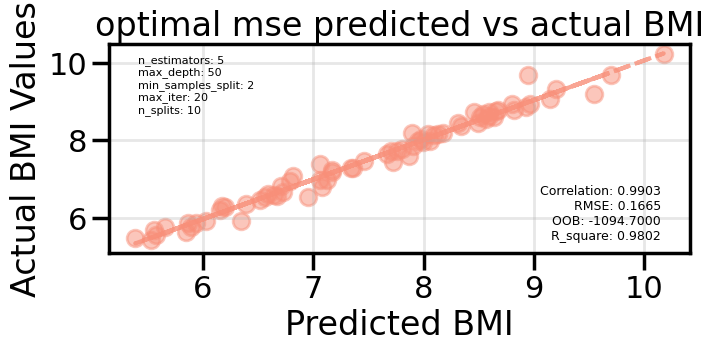

In [32]:
plot_predicted_vs_actual(y_hat_new_mse, Y_new,
                         output_dir, 'cv_clinical_predicted_vs_actual_mse_tuned.png', 
                         best_mse_param_grid, oob_score_mse, '#F88F79', 'optimal mse predicted vs actual BMI')

Correlation between actual and predicted values: 0.9928
Root Mean Squared Error: 0.1505
R-squared Score: 0.9839


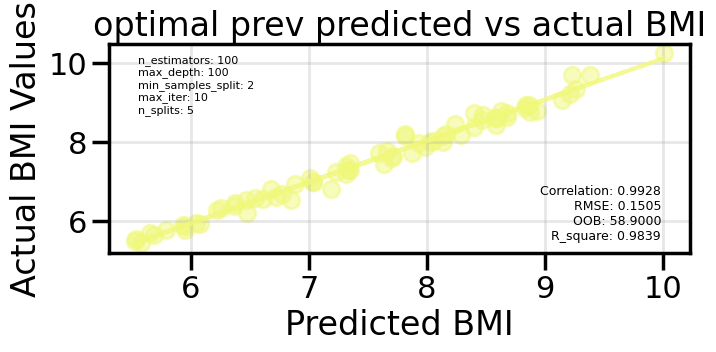

In [33]:
calculate_metrics(Y_new, y_hat_new_prev) #(Y_true, Y_pred)
plot_predicted_vs_actual(y_hat_new_prev, Y_new,
                         output_dir, 'cv_clinical_predicted_vs_actual_prev_tuned.png', 
                         lowest_prev_param_grid, oob_score_prev, '#F0F879', 'optimal prev predicted vs actual BMI')

Correlation between actual and predicted values: 0.9195
Root Mean Squared Error: 0.4679
R-squared Score: 0.8440


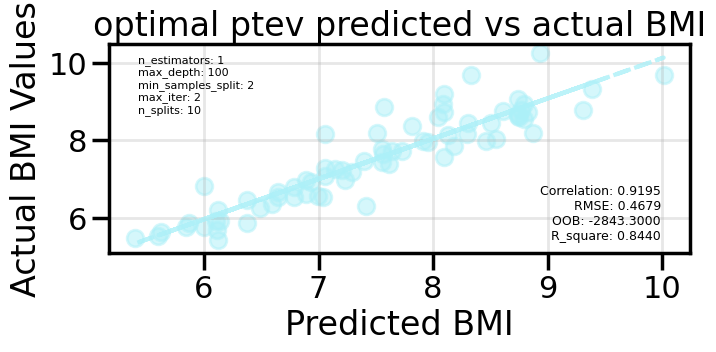

In [34]:
calculate_metrics(Y_new, y_hat_new_ptev) #(Y_true, Y_pred)
plot_predicted_vs_actual(y_hat_new_ptev, Y_new,
                         output_dir, 'cv_clinical_predicted_vs_actual_ptev_tuned.png', 
                         lowest_ptev_param_grid, oob_score_ptev, '#ACF0F8', 'optimal ptev predicted vs actual BMI')

Correlation between actual and predicted values: 0.9893
Root Mean Squared Error: 0.1793
R-squared Score: 0.9771


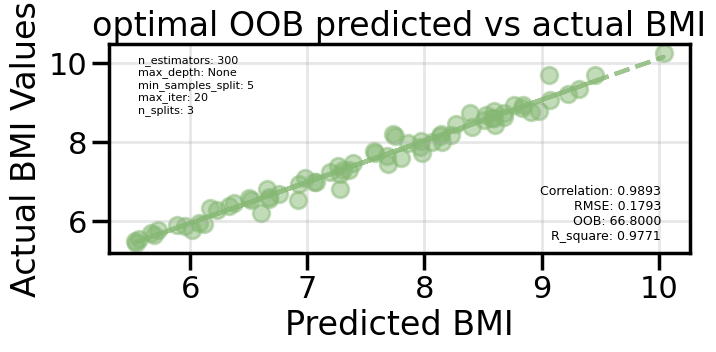

In [35]:
calculate_metrics(Y_new, y_hat_new_oob) #(Y_true, Y_pred)
plot_predicted_vs_actual(y_hat_new_oob, Y_new,
                         output_dir, 'cv_clinical_predicted_vs_actual_oob_tuned.png', 
                         highest_oob_param_grid, oob_score_tuned, '#86B874', 'optimal OOB predicted vs actual BMI')

# Look at feature importances 

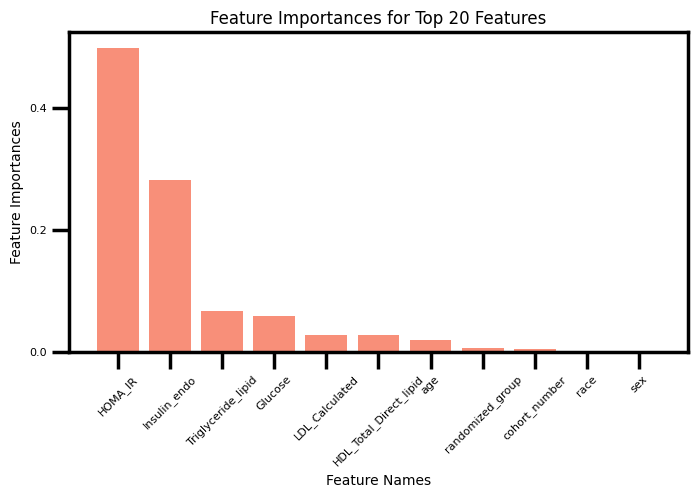

In [36]:
# mse
mse_forest = mrf_mse.trained_fe_model
mse_feature_names = mse_forest.feature_names_in_
mse_feature_importances = mse_forest.feature_importances_
plot_top_20_feature_importances(mse_feature_names, mse_feature_importances, 
                         output_dir, 'mse_feature_importances_clinical', '#F88F79')

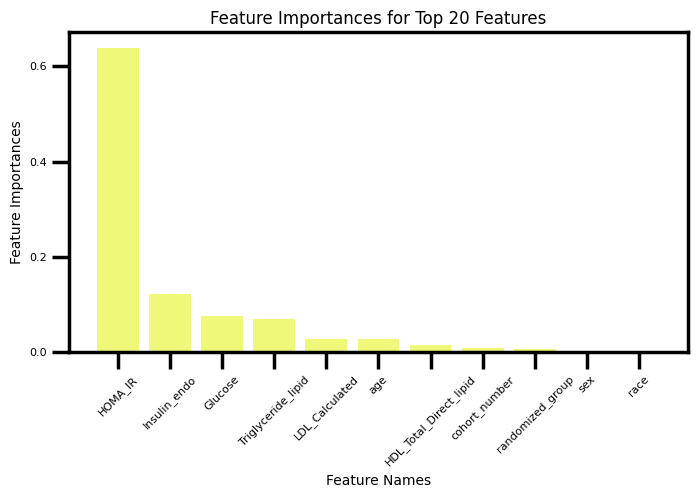

In [37]:
prev_forest = prev_merf.trained_fe_model
prev_feature_names = prev_forest.feature_names_in_
prev_feature_importances = prev_forest.feature_importances_
plot_top_20_feature_importances(prev_feature_names, prev_feature_importances, 
                         output_dir, 'prev_clinical_feature_importances', '#F0F879')

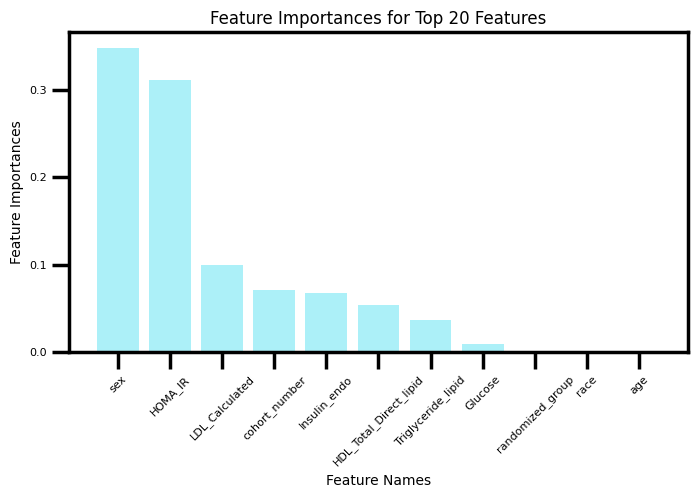

In [38]:
ptev_forest = ptev_merf.trained_fe_model
ptev_feature_names = ptev_forest.feature_names_in_
ptev_feature_importances = ptev_forest.feature_importances_
plot_top_20_feature_importances(ptev_feature_names, ptev_feature_importances, 
                         output_dir, 'ptev_clinical_feature_importances', '#ACF0F8')

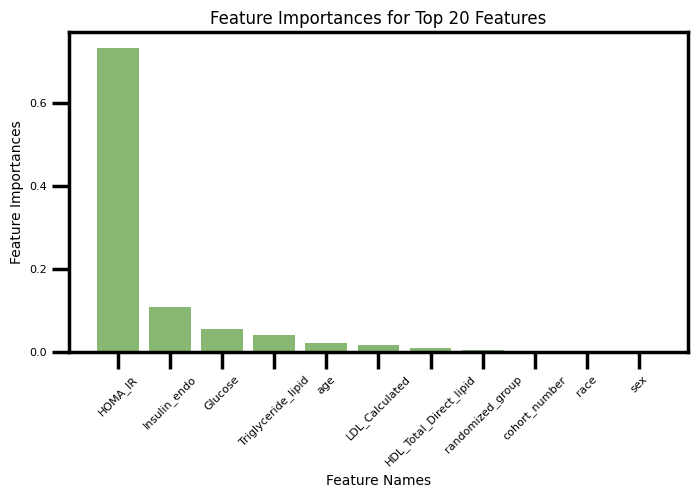

In [39]:
oob_forest = oob_merf.trained_fe_model
oob_feature_names = oob_forest.feature_names_in_
oob_feature_importances = oob_forest.feature_importances_
plot_top_20_feature_importances(oob_feature_names, oob_feature_importances, 
                         output_dir, 'oob_clinical_feature_importances', '#86B874')